In [1]:
import pandas as pd
import arviz as az
import numpy as np
from utils import *
import warnings
warnings.filterwarnings('ignore')
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

def prepare_test_data(mus, sigmas, n=100):

    # Set the random seed for reproducibility
    np.random.seed(123)

    # Generate random values for three clusters
    cluster1 = np.random.normal(loc=mus[0], scale=sigmas[0], size=n)
    cluster2 = np.random.normal(loc=mus[1], scale=sigmas[1], size=n)
    cluster3 = np.random.normal(loc=mus[2], scale=sigmas[2], size=n)

    # Combine the clusters into a single array
    data = np.concatenate([cluster1, cluster2, cluster3])

    # Create the DataFrame
    df = pd.DataFrame(data, columns=['Value'])
    return df

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = prepare_test_data(mus=[10, 20, 5], sigmas=[3, 3, 3])

In [3]:
df = get_data(
    'AAPL', 
    '2018-06-29', '2023-06-09', interval='1d')
df_og= df.copy()


[*********************100%***********************]  1 of 1 completed


In [4]:
df = get_returns(df)

In [5]:
df['moving_average'] = df['returns'].rolling(10, closed='left').mean()

# volatility std * root(T)
df['volatility'] = df['returns'].rolling(10, closed='left').std() * np.sqrt(10) * 1000

In [6]:
# drop na rows
df = df.dropna()

In [7]:
df = df[['returns', 'volatility']]

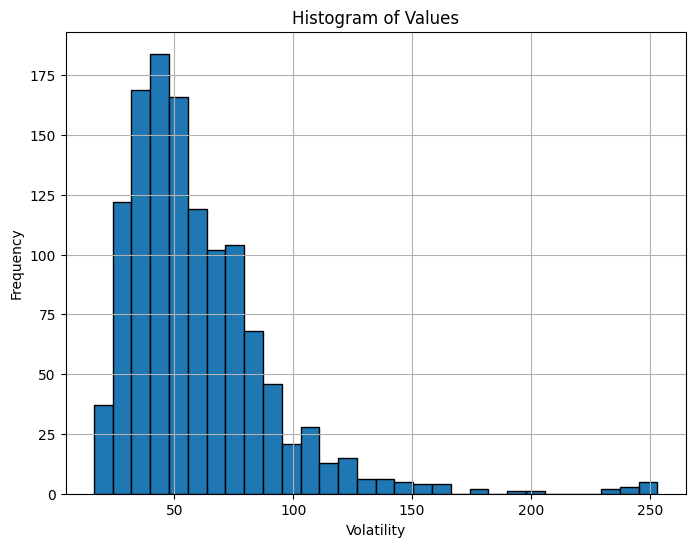

Only 2 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, sigmas, mus]
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to exec

/Users/home/Applications/anaconda3/envs/bayesian/lib/python3.9/site-packages/theano/scalar/basic.py:2893: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/Users/home/Applications/anaconda3/envs/bayesian/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: divide by zero encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/home/Applications/anaconda3/envs/bayesian/lib/python3.9/site-packages/theano/scalar/basic.py:2893: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/Users/home/Applications/anaconda3/envs/bayesian/lib/python3.9/site-packages/theano/scalar/basic.py:2893: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/Users/home/Applications/anaconda3/envs/bayesian/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/home/Applications/anaconda3/envs/b

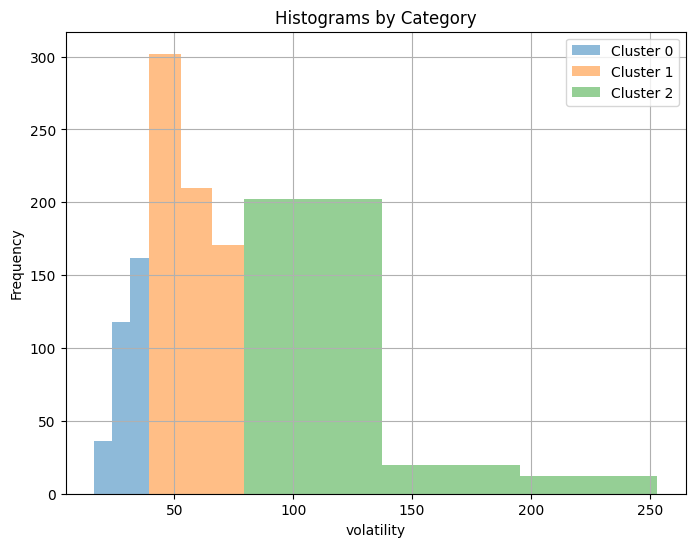

In [8]:
def assign_volatility_cluster(df, mus=[20,60,100], sigmas=[10,10,10]):
    """
    Assigns a volatility cluster to each value in the DataFrame.
    Give a df with a column named 'Value', this should be the volatility measure of a given window. 
    Let the index be the window or any arbitrary index.
    """
    # df drop rows with nan
    df.dropna(inplace=True)
    # Prepare the data
    
    values = df['volatility'].values

    with pm.Model() as model:
        # Specify the number of clusters
        k = 3
        # Priors for the cluster parameters
        mus = pm.Normal('mus', mu=mus, sd=10, shape=k)
        sigmas = pm.HalfNormal('sigmas', sd=10, shape=k)
        weights = pm.Dirichlet('weights', a=np.ones(k))

        # Likelihood
        likelihood = pm.NormalMixture('likelihood', w=weights, mu=mus, sd=sigmas, observed=values)

        # Sample from the posterior
        trace = pm.sample(2, tune=10)
        
    cluster_means = np.array(trace['mus'][-1])
    diff = cluster_means - df['volatility'].values[:, np.newaxis]
    cluster = np.argmin(np.abs(diff), axis=1)
    df['cluster'] = cluster



    return df, trace

    # Extract the cluster assignments

df_clusters, trace = assign_volatility_cluster(df)

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(category3_values, bins=3, alpha=0.5, label='Cluster 0')
plt.hist(category1_values, bins=3, alpha=0.5, label='Cluster 1')
plt.hist(category2_values, bins=3, alpha=0.5, label='Cluster 2')

In [10]:
# df_clusters.value_counts('cluster')
df_clusters.value_counts('cluster') 

cluster
1    683
0    316
2    234
Name: count, dtype: int64

In [11]:
# join df_clusters and df_og
df_clusters = df_clusters.join(df_og, how='left')
df_clusters.reset_index(inplace=True)
df_clusters.head()

,Date,returns,volatility,cluster,Open,High,Low,Close,Adj Close,Volume
0,2018-07-17,0.002829,37.072912,0,47.437500,47.967499,47.299999,47.862499,45.741005,62138000
1,2018-07-18,-0.005484,35.987579,0,47.945000,47.950001,47.482498,47.599998,45.490139,65573600
2,2018-07-19,0.007773,30.236633,0,47.422501,48.137501,47.422501,47.970001,45.843742,81147200
3,2018-07-20,-0.002293,30.192190,0,47.945000,48.107498,47.542500,47.860001,45.738621,82704800
4,2018-07-23,0.000888,28.282898,0,47.669998,47.990002,47.389999,47.902500,45.779240,63957600


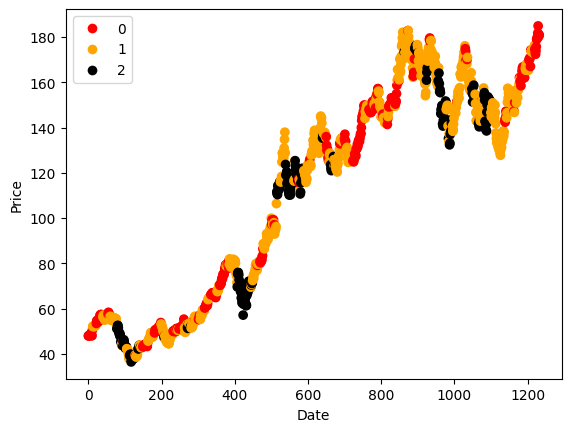

In [12]:
#import mcolors
from matplotlib import colors as mcolors

# Get unique categories and assign corresponding color map
unique_categories = sorted(df_clusters['cluster'].unique())  # Sort the unique categories
color_map = mcolors.ListedColormap(['red', 'orange', 'black'])  # Define specific colors for the categories

# Plot scatter points with color based on cluster
norm = mcolors.Normalize(vmin=0, vmax=len(unique_categories)-1)
plt.scatter(df_clusters.index, df_clusters['High'], c=df_clusters['cluster'].astype('category').cat.codes,
            cmap=color_map, norm=norm)

# Create a legend with matching colors
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map(norm(i)), markersize=8)
                 for i, _ in enumerate(unique_categories)]
plt.legend(legend_labels, unique_categories)

# Set labels for x and y axes
plt.xlabel('Date')
plt.ylabel('Price')

# Display the plot
plt.show()


In [13]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder() 
df['cluster'] = label_encoder.fit_transform(df['cluster'])

(array([ 37., 122., 169., 184., 166., 119., 102., 104.,  68.,  46.,  21.,
         28.,  13.,  15.,   6.,   6.,   5.,   4.,   4.,   0.,   2.,   0.,
          1.,   1.,   0.,   0.,   0.,   2.,   3.,   5.]),
 array([0.01617605, 0.0240755 , 0.03197496, 0.03987441, 0.04777386,
        0.05567331, 0.06357276, 0.07147222, 0.07937167, 0.08727112,
        0.09517057, 0.10307002, 0.11096947, 0.11886893, 0.12676838,
        0.13466783, 0.14256728, 0.15046673, 0.15836619, 0.16626564,
        0.17416509, 0.18206454, 0.18996399, 0.19786344, 0.2057629 ,
        0.21366235, 0.2215618 , 0.22946125, 0.2373607 , 0.24526016,
        0.25315961]),
 <BarContainer object of 30 artists>)

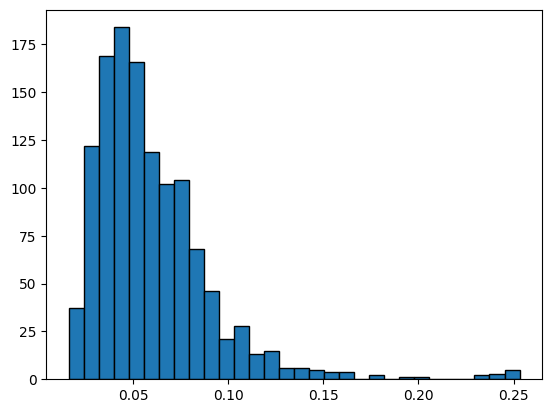

In [9]:
train_cluster_names = df.cluster.unique()
train_cluster_idx = df.cluster.values

n_train_types = len(df.cluster.unique())
df.volatility = df.volatility/1000

df[['cluster', 'volatility']].head()

#plot histogram of volatility
plt.hist(df.volatility, bins=30, edgecolor='black')


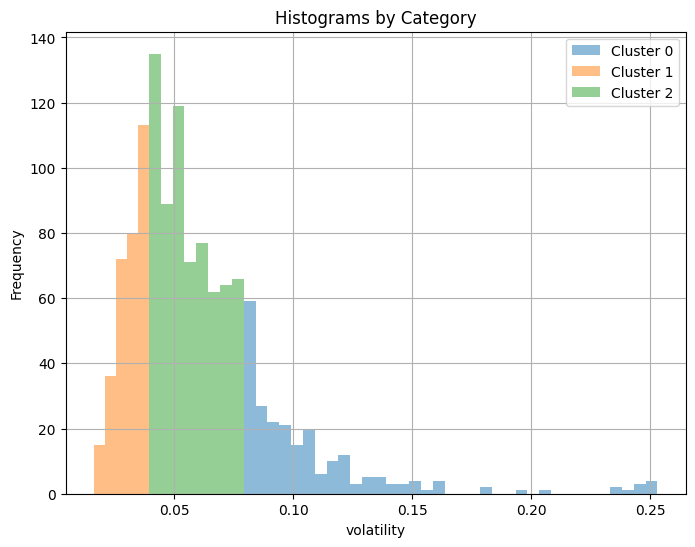

In [16]:
category1_values = df[df.cluster == 0].volatility.values
category2_values = df[df.cluster == 1].volatility.values
category3_values = df[df.cluster == 2].volatility.values

category1_width=category1_values.max() - category1_values.min()
category2_width=category2_values.max() - category2_values.min()
category3_width=category3_values.max() - category3_values.min()
bin_width = 0.005
bins_1 = category1_width / bin_width
bins_2 = category2_width / bin_width
bins_3 = category3_width / bin_width
plt.figure(figsize=(8, 6))
plt.hist(category3_values, bins=int(round(bins_3)), alpha=0.5, label='Cluster 0')
plt.hist(category1_values, bins=int(round(bins_1)), alpha=0.5, label='Cluster 1')
plt.hist(category2_values, bins=int(round(bins_2)), alpha=0.5, label='Cluster 2')

plt.xlabel('volatility')
plt.ylabel('Frequency')
plt.title('Histograms by Category')
plt.legend()
plt.grid(True)


In [15]:
with pm.Model() as hierarchical_model:
    # global model parameters
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0., sd=100)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 5.)
    β_μ = pm.Normal('β_μ', mu=0., sd=100)
    β_σ = pm.HalfNormal('β_σ', 5.)

    # train type specific model parameters
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=n_train_types)  
    # Intercept for each train type, distributed around train type mean 
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=n_train_types)
    # Model error
    eps = pm.HalfCauchy('eps', 5.)

    return_est = α_tmp[train_cluster_idx] + β[train_cluster_idx]*df.cluster.values

    # Data likelihood
    return_like = pm.Normal('return_like', mu=return_est, sd=eps, observed=df.returns)
    
with hierarchical_model:
    hierarchical_trace = pm.sample(20, tune=100, target_accept=.9)
    
pm.traceplot(hierarchical_trace, var_names=['α_μ_tmp', 'β_μ', 'α_σ_tmp', 'β_σ', 'eps'])


Only 20 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.configdefaults): g++ not detected ! Theano 

Got error No model on context stack. trying to find log_likelihood in translation.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

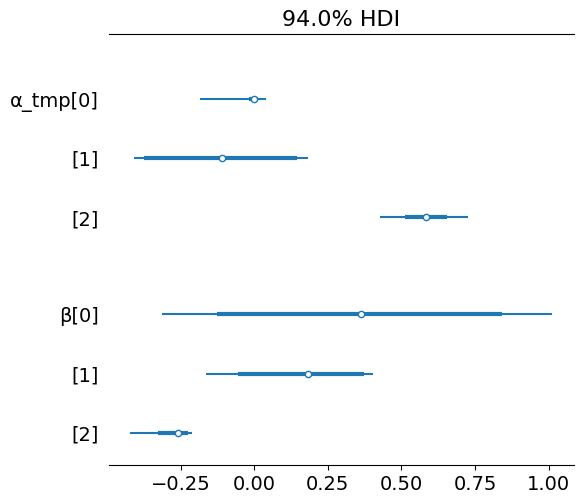

In [ ]:
az.plot_forest(hierarchical_trace, var_names=['α_tmp', 'β'], combined=True)

In [ ]:
ppc = pm.sample_posterior_predictive(hierarchical_trace, samples=2000, model=hierarchical_model)
az.r2_score(df.returns.values, ppc['return_like'])

r2        0.499989
r2_std    0.000080
dtype: float64